In [1]:
from stellargraph.core import StellarGraph
from stellargraph.mapper import AdjacencyPowerGenerator
from stellargraph.layer.watch_your_step import WatchYourStep
from stellargraph.utils.loss import graph_log_likelihood

from matplotlib import pyplot as plt
from tensorflow.keras import optimizers, Model, layers, regularizers
from sklearn import preprocessing, feature_extraction, model_selection

import networkx as nx
import random
import numpy as np
import pandas as pd
import os

## Loading in the data

In [2]:
data_dir = os.path.expanduser("~/data/cora")
os.listdir(data_dir)
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")

feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)

## Creating the model

First, we create a StellarGraph object from our NetworkX graph. From this, we create an `AdjacencyPowerGenerator` which loops through the rows of the first `num_powers` of the adjacency matrix.

In [3]:
G = StellarGraph(Gnx)
generator = AdjacencyPowerGenerator(G, num_powers=10)

/Users/kieranricardo/PycharmProjects/origin-stellargaph/stellargraph/stellargraph/core/experimental.py:88: ExperimentalWarning: AdjacencyPowerGenerator is experimental: lack of unit tests. It may be difficult to use and may have major changes at any time.
  warnings.warn(direct_msg, ExperimentalWarning)


Next, we use the `WatchYourStep` class to create trainable node embeddings and expected random walks.

In [4]:
wys = WatchYourStep(
    generator, num_walks=80, 
    embedding_dimension=65, 
    attention_regularizer=regularizers.l2(0.5),
)
x_in, x_out = wys.build()

/Users/kieranricardo/PycharmProjects/origin-stellargaph/stellargraph/stellargraph/core/experimental.py:88: ExperimentalWarning: WatchYourStep is experimental: lack of unit tests. It may be difficult to use and may have major changes at any time.
  warnings.warn(direct_msg, ExperimentalWarning)
/Users/kieranricardo/PycharmProjects/origin-stellargaph/stellargraph/stellargraph/core/experimental.py:88: ExperimentalWarning: AttentiveWalk is experimental: lack of unit tests. It may be difficult to use and may have major changes at any time.
  warnings.warn(direct_msg, ExperimentalWarning)


We use the graph log likelihood as our loss function.

In [5]:
model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=graph_log_likelihood, optimizer='adam')

/Users/kieranricardo/PycharmProjects/origin-stellargaph/stellargraph/stellargraph/core/experimental.py:88: ExperimentalWarning: graph_log_likelihood is experimental: lack of unit tests. It may be difficult to use and may have major changes at any time.
  warnings.warn(direct_msg, ExperimentalWarning)


## Training

We now create a training generator and fit our model.

In [6]:
batch_size = 10
train_gen = generator.flow(batch_size=batch_size, threads=10)

history = model.fit(
    train_gen, epochs=40, 
    verbose=1,
    steps_per_epoch=int(len(G.nodes()) // batch_size))

/Users/kieranricardo/anaconda3/envs/tf2-stellar/lib/python3.6/site-packages/tensorflow_core/python/autograph/impl/api.py:396: ExperimentalWarning: partial_powers is experimental: lack of unit tests. It may be difficult to use and may have major changes at any time.
  return py_builtins.overload_of(f)(*args)
/Users/kieranricardo/anaconda3/envs/tf2-stellar/lib/python3.6/site-packages/tensorflow_core/python/autograph/impl/api.py:396: ExperimentalWarning: select_row_from_sparse_tensor is experimental: lack of unit tests. It may be difficult to use and may have major changes at any time.
  return py_builtins.overload_of(f)(*args)


Train for 270 steps
Epoch 1/40


/Users/kieranricardo/PycharmProjects/origin-stellargaph/stellargraph/stellargraph/core/experimental.py:88: ExperimentalWarning: graph_log_likelihood is experimental: lack of unit tests. It may be difficult to use and may have major changes at any time.
  warnings.warn(direct_msg, ExperimentalWarning)


270/270 [==============================] - 2s 9ms/step - loss: 3.4443
Epoch 2/40
270/270 [==============================] - 2s 6ms/step - loss: 3.1602
Epoch 3/40
270/270 [==============================] - 2s 6ms/step - loss: 2.8255
Epoch 4/40
270/270 [==============================] - 2s 6ms/step - loss: 2.3141
Epoch 5/40
270/270 [==============================] - 2s 6ms/step - loss: 1.7569
Epoch 6/40
270/270 [==============================] - 2s 6ms/step - loss: 1.3369
Epoch 7/40
270/270 [==============================] - 1s 6ms/step - loss: 1.0851
Epoch 8/40
270/270 [==============================] - 2s 6ms/step - loss: 0.9407
Epoch 9/40
270/270 [==============================] - 2s 6ms/step - loss: 0.8510
Epoch 10/40
270/270 [==============================] - 2s 7ms/step - loss: 0.7887
Epoch 11/40
270/270 [==============================] - 2s 6ms/step - loss: 0.7455
Epoch 12/40
270/270 [==============================] - 2s 6ms/step - loss: 0.7152
Epoch 13/40
270/270 [===============

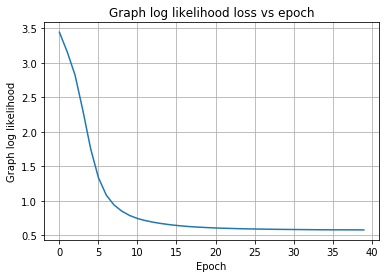

In [7]:
plt.title("Graph log likelihood loss vs epoch")
plt.xlabel("Epoch")
plt.ylabel("Graph log likelihood")
plt.grid()
plt.plot(history.history['loss'])
plt.show()

## Visualizing Embeddings

Now we use TSNE to visualize the embeddings.

In [8]:
nodelist = list(G.nodes())

inputs = layers.Input(batch_shape=(len(nodelist),), dtype='int64')
left_out = model.get_layer('LEFT_EMBEDDINGS')(inputs)
right_out = model.get_layer('RIGHT_EMBEDDINGS')(inputs)
out = layers.concatenate([left_out, right_out])

embedding_model = Model(inputs=inputs, outputs=out)
embeddings = embedding_model.predict(np.arange(len(nodelist)))

In [9]:
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None)
node_data.set_index(0, inplace=True)

labels = node_data[node_data.columns[-1]].loc[nodelist]

In [10]:
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

target_encoding = OneHotEncoder(sparse=False)

transform = TSNE

trans = transform(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(embeddings), index=nodelist)

label_vectors = target_encoding.fit_transform(labels.values.reshape(-1, 1))
emb_transformed['label'] = np.argmax(label_vectors, 1)

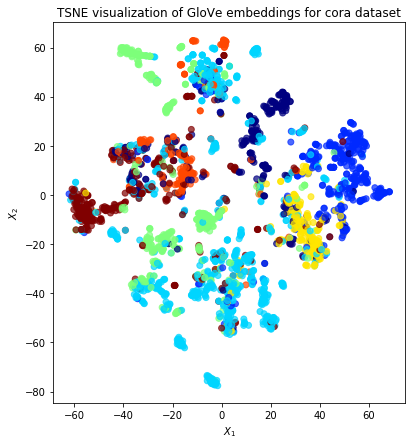

In [11]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)

ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GloVe embeddings for cora dataset'.format(transform.__name__))
plt.show()

# Classification

Cora node classification. Currently this section is especially messy but is here to demonstrate that the node embeddings yield a high classification accuray.

In [12]:
train_node_idx = np.random.choice(np.arange(label_vectors.shape[0]), size=300, replace=False)
test_node_idx = [i for i in range(label_vectors.shape[0]) if not i in train_node_idx]

training_labels = label_vectors.copy()
training_labels[test_node_idx] = 0

In [13]:
d = embeddings.shape[1] // 2

predictions = np.dot(
    np.exp(np.dot(embeddings[:, :d], embeddings[:, d:].transpose())),
    training_labels
)

np.mean(np.argmax(predictions[test_node_idx], 1) == np.argmax(label_vectors[test_node_idx], 1))

0.6989202657807309